# Домашнее задание
Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [196]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2023-09-06 12:50:27--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 172.253.123.139, 172.253.123.102, 172.253.123.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.123.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/93vjhkbkha8lutvg8r5t2dts9rsj6uhk/1694004600000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=fd01f576-7fe1-4c8c-a000-c384c347a5e4 [following]
--2023-09-06 12:50:27--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/93vjhkbkha8lutvg8r5t2dts9rsj6uhk/1694004600000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=fd01f576-7fe1-4c8c-a000-c384c347a5e4
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 142.250.97.132, 2

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [198]:
df = pd.read_csv('/content/airline-passengers.csv')

In [199]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Text(0.5, 1.0, 'кол-во пассажиров')

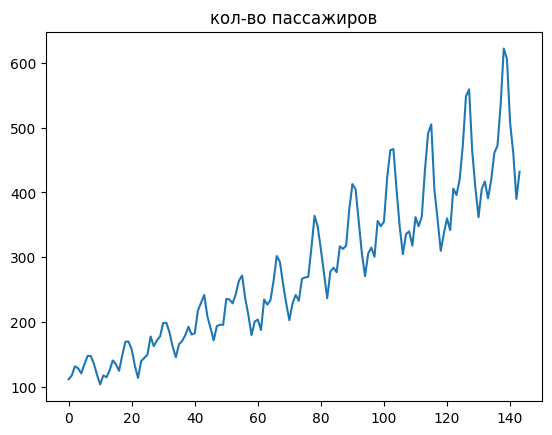

In [200]:
plt.plot(df.index, df['Passengers'])
plt.title('кол-во пассажиров')

In [201]:
df['Month'] = pd.to_datetime(df['Month'])

In [202]:
df['year'] = df.Month.dt.year
df['month'] = df.Month.dt.month
df.drop('Month', axis=1, inplace=True)

In [203]:
# разобъем на train and test

train_size = 105
bias = 7
train = df[:train_size]
test = df[train_size + bias:]

In [204]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[['month', 'year']] = scaler.fit_transform(train[['month', 'year']])
test[['month', 'year']] = scaler.transform(test[['month', 'year']])

<ipython-input-204-4b94afe7f198>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['month', 'year']] = scaler.fit_transform(train[['month', 'year']])
<ipython-input-204-4b94afe7f198>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['month', 'year']] = scaler.transform(test[['month', 'year']])


In [205]:
train.shape, test.shape

((105, 3), (32, 3))

In [206]:
# длина истории
x_len = 5

# горизонт предсказания
future = 1

# параметры модели
learning_rate = 0.01
batch_size = 32
epochs = 40

In [207]:
start = x_len + future
end = start + train_size

print(start, end)

6 111


In [208]:
features = ['month', 'year']
target = ['Passengers']

In [209]:
X_train = train[features].values
y_train = df.iloc[start:end][target].values

x_end = len(test) - x_len - future
label_start = len(train) + bias + x_len + future

X_test = test.iloc[:x_end][features].values
y_test = df.iloc[label_start:][target].values

In [210]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((105, 2), (105, 1), (26, 2), (26, 1))

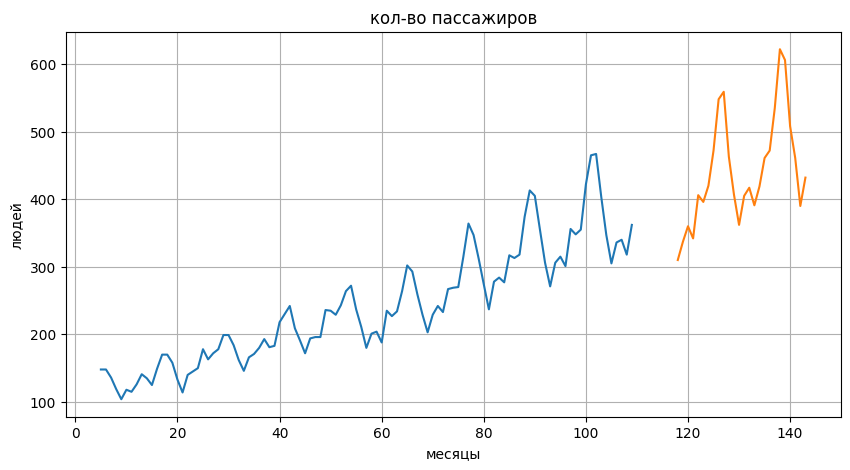

In [211]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_test[:])
plt.grid('on')
plt.xlabel('месяцы')
plt.ylabel('людей')
plt.title('кол-во пассажиров')
plt.show()

In [212]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length = x_len,
    sampling_rate = 1,
    batch_size = batch_size
)

dataset_test = timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length = x_len,
    sampling_rate = 1,
    batch_size = batch_size
)

In [213]:
for item in dataset_train:
  # print(item)
  inputs, targets = item
  # print(inputs)
  print(inputs.shape)
  # print(targets)
  print(targets.shape)
  break

(32, 5, 2)
(32, 1)


In [241]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(128, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Conv1D(128, 3))
model.add(Conv1D(64, 1))
model.add(Flatten())
# model.add(BatchNormalization())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(1))

In [242]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [243]:
model.compile(
    optimizer='Adam',
    loss='mse',
    metrics='mae'
)

best_model = ModelCheckpoint(
    filepath='best_model_',
    monitor='val_mae',
    save_weights_only=True,
    verbose=1,
    save_best_only=True
)

history = model.fit(
    dataset_train,
    epochs=150,
    validation_data=dataset_test,
    callbacks=[best_model]
)

Epoch 1/150
4/4 [==============================] - ETA: 0s - loss: 62726.6328 - mae: 236.1792 
Epoch 1: val_mae improved from inf to 441.28586, saving model to best_model_
4/4 [==============================] - 7s 375ms/step - loss: 62726.6328 - mae: 236.1792 - val_loss: 201877.7500 - val_mae: 441.2859
Epoch 2/150
4/4 [==============================] - ETA: 0s - loss: 62555.4414 - mae: 235.8408
Epoch 2: val_mae improved from 441.28586 to 440.54056, saving model to best_model_
4/4 [==============================] - 0s 56ms/step - loss: 62555.4414 - mae: 235.8408 - val_loss: 201204.0000 - val_mae: 440.5406
Epoch 3/150
4/4 [==============================] - ETA: 0s - loss: 62200.6289 - mae: 235.2079
Epoch 3: val_mae improved from 440.54056 to 438.27295, saving model to best_model_
4/4 [==============================] - 0s 55ms/step - loss: 62200.6289 - mae: 235.2079 - val_loss: 199149.9844 - val_mae: 438.2729
Epoch 4/150
4/4 [==============================] - ETA: 0s - loss: 61177.1328 - 

In [244]:
model.load_weights('best_model_')
model.evaluate(dataset_test)

1/1 [==============================] - 0s 80ms/step - loss: 562.2669 - mae: 19.2887


[562.2669067382812, 19.28874397277832]

In [245]:
prediction = model.predict(dataset_train)
pred_test = model.predict(dataset_test)

1/1 [==============================] - 0s 67ms/step


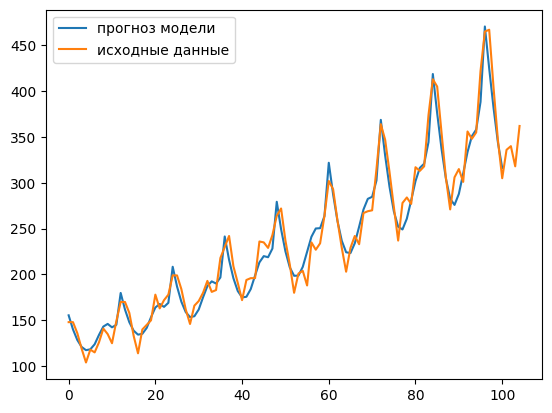

In [246]:
plt.plot(prediction, label='прогноз модели')
plt.plot(y_train, label='исходные данные')
plt.legend()
plt.show()

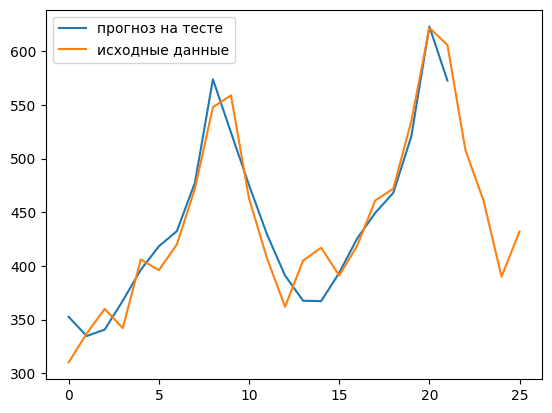

In [248]:
plt.plot(pred_test, label='прогноз на тесте')
plt.plot(y_test, label='исходные данные')
plt.legend()
plt.show()